In [122]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_07.ipynb")

In [123]:
rng_seed = 42

## Homework 7

## <em> Linear Regression, Regularization, and Logistic & Softmax Regression</em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

### Imports

In [124]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Problem 1 - Ising Model

In earlier HW, we did a simple ML analysis by fitting datasets generated by polynomials in the presence of noise, and this highlighted the fundamental tension common to all ML models between how well we fit the training dataset and predictions on new data.

Here, we consider the problem of learning the Hamiltonian for the Ising model (https://en.wikipedia.org/wiki/Ising_model) using the linear regression. This is a lattice model proposed to explain ferromagnetism in materials. In other physics courses, you learned that elementary particles have an intrinsic property called spin, which carries magnetic moments. The magnetism of a bulk material is made up of the magnetic dipole moments of the atomic spins inside the material. The classical Ising model postulates a lattice with a spin $S$ on each site.

Now consider the 1D Ising model with nearest-neighbor interactions

$$H[\boldsymbol{S}]=-J\sum_{j=1}^L S_{j}S_{j+1}$$

on a chain of length $L$ with periodic boundary conditions and $S_j=\pm 1$ Ising spin variables. $J$ is the nearest-neighbor spin interaction

With $J=1$, we draw a large number of spin configurations. We can draw them $n$ number of times: we have $n$ number of $\boldsymbol{S}^i$, which is a vector of length $L$. Hence, $\boldsymbol{S}$ is a matrix of $n \times L$.



<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 1. You are given 1000 random Ising states with $L=40$. (i.e. this state matrix $\boldsymbol{S}$ should have the dimension $1000 \times 40$, and its array elements are either 1 or -1.) Define a function which computes the energies $H$ given $\boldsymbol{S}$. Calculate the energies of the first 10 states. (Do not shuffle the states!) </i></span> <br>

Hint: Each state $\boldsymbol{S}^i$ has its own energy, so $H[\boldsymbol{S}]$ is a vector of length $n=1000$.

We adopt the periodic boundary conditions, so when $j=L$, $j+1=1$.

In [125]:
S = np.loadtxt("./state.txt")
print( np.shape(S) )
print( S )

(1000, 40)
[[-1.  1.  1. ... -1.  1. -1.]
 [-1.  1.  1. ...  1. -1. -1.]
 [-1. -1.  1. ... -1. -1.  1.]
 ...
 [-1.  1. -1. ... -1. -1.  1.]
 [-1. -1.  1. ... -1. -1.  1.]
 [-1.  1.  1. ...  1.  1. -1.]]


In [126]:
L = 40
def ising_energies(S,L):
    N = S.shape[0]
    energies = np.zeros(N)    
    for idx in range(N):
        state = S[idx]  # 1D array of length L
        energy = 0
        for j in range(L):
            energy -= state[j] * state[(j + 1) % L]
        energies[idx] = energy
    return energies

# calculate Ising energies
energies=ising_energies(S,L)

print( energies[0:10] )

[ 8.  4.  0.  0. 12. -4.  4.  8. -4. -4.]


In [127]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- END QUESTION -->

Now, suppose you do not have the knowledge of the above Hamiltonian. Instead, you are given a data set of $i=1\ldots n$ points of the form $\{(H[\boldsymbol{S}^i],\boldsymbol{S}^i)\}$. Your task is to learn the Hamiltonian using Linear regression techniques.

In the absence of any prior knowledge, one sensible choice is the all-to-all Ising model

$$
H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i.
$$
Notice that this model is uniquely defined by the non-local coupling strengths $J_{jk}$ which we want to learn. Importantly, this model is linear in ${\mathbf J}$ which makes it possible to use linear regression.

To apply linear regression, we would like to recast this model in the form
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$

where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{j}^iS_{k}^i \}_{j,k=1}^L$, and the index $i$ runs over the samples in the data set. To make the analogy complete, we can also represent the dot product by a single index $p = \{j,k\}$, i.e. $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Note that the regression model does not include the minus sign, so we expect to learn negative $J$'s.

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 2. Create the matrix $\mathbf{X}$. Print $\mathbf{X}$. </i></span> <br>

Hint: For each state $i$, we have the state vector $\boldsymbol{S}^i$. $\mathbf{X}^i$ = $\boldsymbol{S}^i_{.T} \otimes \boldsymbol{S}^i_{.T}$, where $\otimes$ is the outer product. (https://en.wikipedia.org/wiki/Outer_product)

The dimension of $\mathbf{X}^i$ is $L \times L$. Hence, $\mathbf{X}$ has the diemension $n \times L \times L$. Reshape it so that it has the dimension $n \times L*L$ ($1000 \times 1600$).

You can either use the for-loop or use np.einsum to do the outer product (https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.einsum.html).

In [128]:
X = np.einsum('ij,ik->ijk', S, S).reshape(-1, L*L)

In [129]:
print(X)

[[ 1. -1. -1. ...  1. -1.  1.]
 [ 1. -1. -1. ... -1.  1.  1.]
 [ 1.  1. -1. ... -1. -1.  1.]
 ...
 [ 1. -1.  1. ... -1. -1.  1.]
 [ 1.  1. -1. ... -1. -1.  1.]
 [ 1. -1. -1. ... -1. -1.  1.]]


In [130]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

We can now do the linear regression.
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$
Hence, you have data ($\mathbf{X}, H$)

<span style="color:blue"> <i> 3. Split the data into training and test samples. We choose that the first 70% of $n$ states are training samples, the remaining 30% test samples. No need to shuffle the data because we are already given the random set of states. Print the diemension of training and test samples.</i></span> <br>

Hint: Here, H means $H[\boldsymbol{S}]$ or $H[\mathbf{X}]$ we calculated in Part 1.

In [131]:
Y = ising_energies(S,L)
X_train= X[:700]
Y_train= Y[:700]
X_test= X[700:]
Y_test= Y[700:]

print( X_train.shape )
print( Y_train.shape ) 
print( X_test.shape )
print( Y_test.shape )

(700, 1600)
(700,)
(300, 1600)
(300,)


In [132]:
grader.check("q1.3")

q1.3 results: All test cases passed!

<!-- END QUESTION -->

In earlier HW, you used "linear_model.LinearRegression()" from scikit-learn to do the linear regression and found that using a complex model can result in overfitting. To resolve such issues, we use regularization in machine learning. A regression model that uses $L_1$ regularization technique is called Lasso Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and model which uses $L_2$ is called Ridge Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

First, set up Lasso and Ridge regression models.

In [133]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

ridge = linear_model.Ridge()
lasso = linear_model.Lasso()

<!-- BEGIN QUESTION -->

For each regression model, do the following:

1. Choose the regularization parameter $\lambda$.
2. Set the parameter using `.set_params()` <br>
    e.g. `lambda = 1; ridge.set_params(alpha=lambda)`
3. Fit the model<br>
    e.g. `ridge.fit(training X samples, training H samples)`
4. Compute the coefficient of determination $R^2$ of the prediction. This quantifies the performance of prediction.

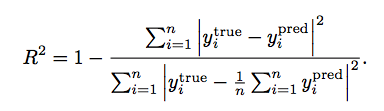

    e.g. `ridge.score(training or test X samples, training or test H samples)`

<span style="color:blue"> <i> 4. Let lambda = np.logspace(-4, 5, 10). Compute $R^2$ score for each lambda value and plot it as a function of lambda. Do both Ridge and LASSO regression. Also, make sure to show results for both training and test samples. (4 plots, or 4 lines on the same plot) </i></span> <br>


In [134]:
lmbdas = np.logspace(-4, 5, 10)
train_errors_ridge = np.zeros(len(lmbdas))
test_errors_ridge = np.zeros(len(lmbdas))
train_errors_lasso = np.zeros(len(lmbdas))
test_errors_lasso = np.zeros(len(lmbdas))

# Compute the R^2 score:
for idx, lmbda in enumerate(lmbdas):
    # Ridge regression
    ridge.set_params(alpha=lmbda)
    ridge.fit(X_train, Y_train)
    train_errors_ridge[idx] = ridge.score(X_train, Y_train)
    test_errors_ridge[idx] = ridge.score(X_test, Y_test)
    
    # Lasso regression
    lasso.set_params(alpha=lmbda)
    lasso.fit(X_train, Y_train)
    train_errors_lasso[idx] = lasso.score(X_train, Y_train)
    test_errors_lasso[idx] = lasso.score(X_test, Y_test)

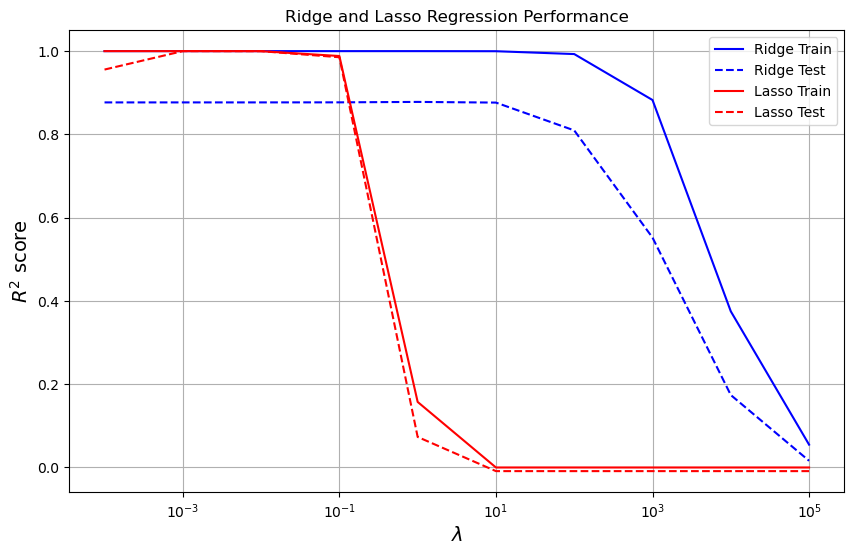

In [135]:
plt.figure(figsize=(10, 6))
plt.semilogx(lmbdas, train_errors_ridge, 'b-', label='Ridge Train')
plt.semilogx(lmbdas, test_errors_ridge, 'b--', label='Ridge Test')
plt.semilogx(lmbdas, train_errors_lasso, 'r-', label='Lasso Train')
plt.semilogx(lmbdas, test_errors_lasso, 'r--', label='Lasso Test')
plt.xlabel('$\\lambda$', fontsize=14)
plt.ylabel('$R^2$ score', fontsize=14)
plt.legend()
plt.title('Ridge and Lasso Regression Performance')
plt.grid(True)
plt.show()

In [136]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

You should find that the regularization parameter $\lambda$ affects the Ridge and LASSO regressions at scales, separated by a few orders of magnitude. Therefore, it is considered good practice to always check the performance for the given model and data with $\lambda$.

At $\lambda\to 0$ and $\lambda\to\infty$, both models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity.

While the Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).


***

So far we have focused on learning from datasets for which there is a continuous output. Classification problems, however, are concerned with outcomes taking the form of discrete variables (i.e. categories). Here, given a spin configuration of, say, the 2D Ising model, we’d like to identify its phase (e.g. ordered/disordered).

Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$.

An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. If successful, this can be used to locate the position of the critical point in more complicated models where an exact analytical solution has so far remained elusive.

In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself.

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

First, load the data for the following three types of phases: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$).

We are given data for $T/J=1.0$, $T/J=2.25$, and $T/J=3.0$.

In [137]:
import pickle,os
from sklearn.model_selection import train_test_split

# load data

# state vector
file_name = "./Ising2DFM_reSample_L40_T=All_labels.pkl"
state_vector = pickle.load(open(file_name,'rb'))

# ordered phases
file_name = "./Ising2DFM_reSample_L40_T=1.00.pkl"
data = pickle.load(open(file_name,'rb'))
data = np.unpackbits(data).reshape(-1, 1600)
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

X_ordered=data
Y_ordered=state_vector[30000:40000]

# critical phases
file_name = "./Ising2DFM_reSample_L40_T=2.25.pkl"
data = pickle.load(open(file_name,'rb'))
data = np.unpackbits(data).reshape(-1, 1600)
data=data.astype('int')
data[np.where(data==0)]=-1

X_critical=data
Y_critical=state_vector[80000:90000]

# disordered phases
file_name = "./Ising2DFM_reSample_L40_T=3.00.pkl"
data = pickle.load(open(file_name,'rb'))
data = np.unpackbits(data).reshape(-1, 1600)
data=data.astype('int')
data[np.where(data==0)]=-1

X_disordered=data
Y_disordered=state_vector[110000:120000]

L = 40

You have $\textbf{X}$ for ordered, critical and disordered phases and corresponding state vector $Y$.
For each phase (ordered, critical or disordered), we have 500 different $40\times 40$ square lattices. So $\textbf{X}$ has the dimension $500 \times 40 \times 40$. We reshape it into $500 \times 40*40$ = $500 \times 1600$. The state vector is a vector of length 500.

Run the below cell to plot examples of typical states of the 2D Ising model for three different temperatures.

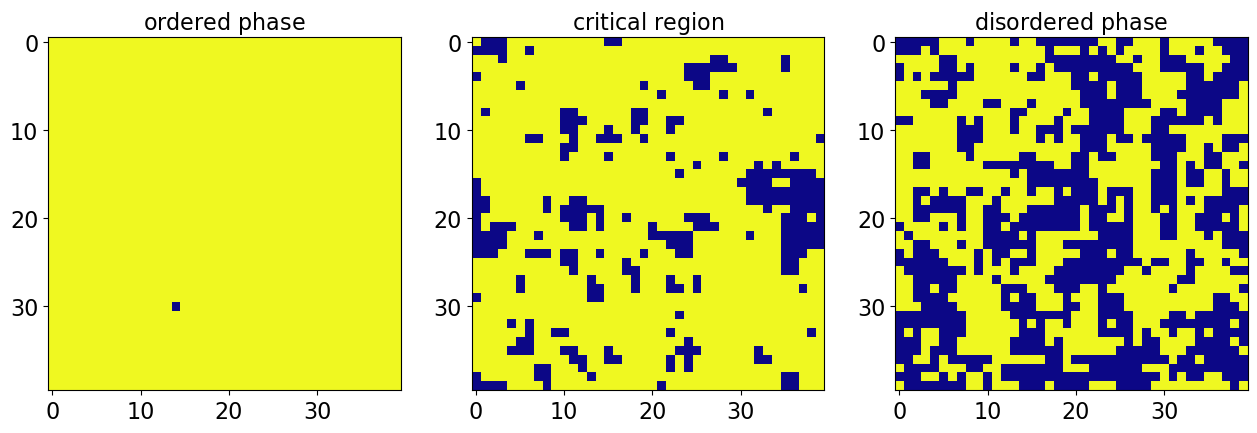

In [138]:
# plot few Ising states
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_args=dict(cmap='plasma_r')

fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[100].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[100].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[100].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 5. Combine ordered phase samples and disordered phase samples using np.concatenate. Using train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), split it into training and test samples. Set train_size = 0.5. (50% of $X$ is our training samples.) Print the dimension of training and test samples. </i></span> <br>

Using logistic regression, we will investigate how accurately we can distinguish between ordered and disordered phases.

In [139]:
X = np.concatenate((X_ordered, X_disordered))
Y = np.concatenate((Y_ordered, Y_disordered))
X_train,X_test,Y_train,Y_test= train_test_split(X, Y, train_size=0.5, random_state=rng_seed)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(10000, 1600)
(10000,)
(10000, 1600)
(10000,)


In [140]:
grader.check("q1.5")

q1.5 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Here, we compare the performance of two different optimization routines: a liblinear (the default one for scikit's logistic regression, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), and stochastic gradient descent (SGD, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). It is important to note that all these methods have built-in regularizers, and doing regularization is crucial in order to prevent overfitting.

For each optimization routine, do the following:

1. Choose the regularization parameter $\lambda$.
2. Define the logistic regressor <br>
    e.g. $\textbf{liblinear}$: `logreg=linear_model.LogisticRegression(C=1.0/lambda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5)`<br>
    e.g. $\textbf{SGD}$: `logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, shuffle=True, random_state=1, learning_rate='optimal')`<br>
    Use the above parameters, but you can play with them if you wish.
3. Fit the model<br>
    e.g. `logreg.fit(training X samples, training H samples)`
4. Compute the mean accuracy on the given data.
    e.g. `logreg.score(training or test X samples, training or test H samples)`

<span style="color:blue"> <i> 6. Let `lambda = np.logspace(-5,5,11)`. Compute the mean accuracy for each lambda value and plot it as a function of lambda. Do both liblinear and SGD. Also, show results for both training, test samples, and critical phase samples. (6 plots) What do you find? </i></span> <br>


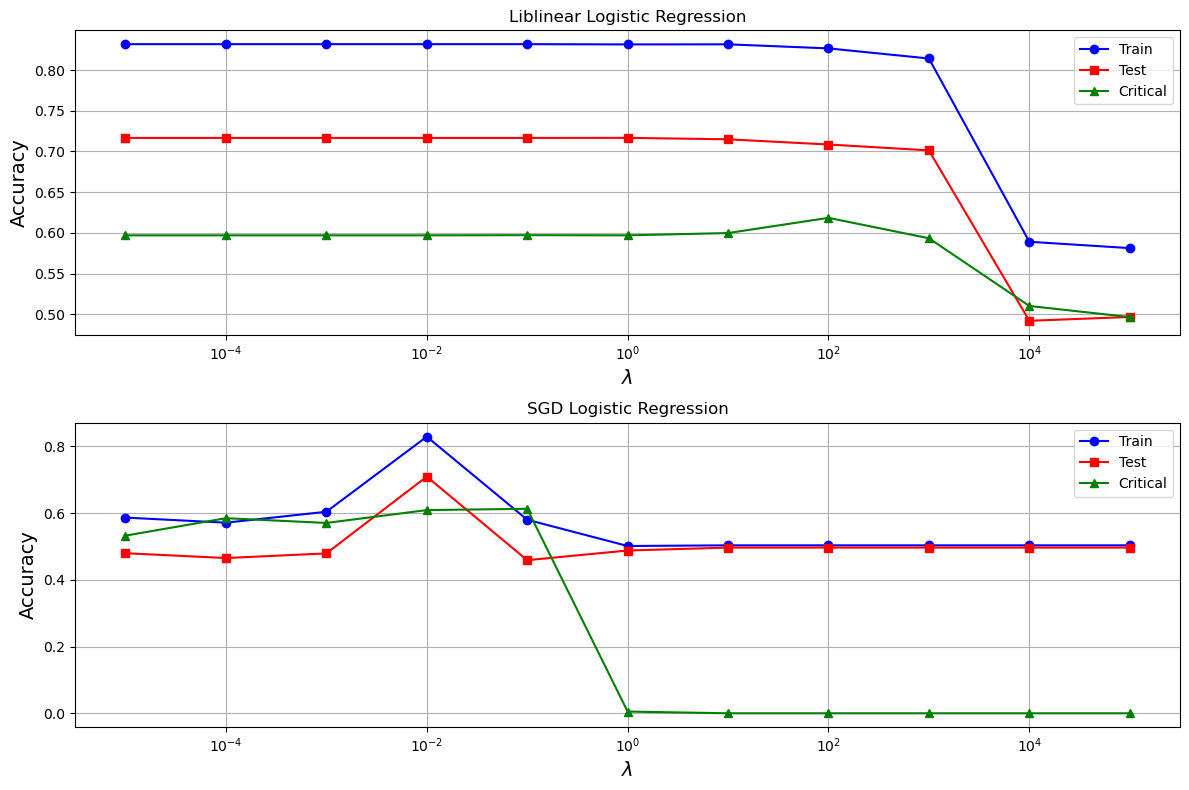

In [141]:
lmbdas = np.logspace(-5, 5, 11)

# Initialize numpy arrays for results
train_accuracy_liblinear = np.zeros(len(lmbdas))
test_accuracy_liblinear = np.zeros(len(lmbdas))
critical_accuracy_liblinear = np.zeros(len(lmbdas))

train_accuracy_SGD = np.zeros(len(lmbdas))
test_accuracy_SGD = np.zeros(len(lmbdas))
critical_accuracy_SGD = np.zeros(len(lmbdas))

for idx, lmbda in enumerate(lmbdas):
    # Liblinear
    logreg = linear_model.LogisticRegression(C=1.0/lmbda, random_state=1, verbose=0, max_iter=1000, tol=1E-5, solver='liblinear')
    logreg.fit(X_train, Y_train)
    train_accuracy_liblinear[idx] = logreg.score(X_train, Y_train)
    test_accuracy_liblinear[idx] = logreg.score(X_test, Y_test)
    critical_accuracy_liblinear[idx] = logreg.score(X_critical, Y_critical)
    
    # SGD
    logreg_SGD = linear_model.SGDClassifier(loss='log_loss', penalty='l2', alpha=lmbda, max_iter=100, shuffle=True, random_state=1, learning_rate='optimal')
    logreg_SGD.fit(X_train, Y_train)
    train_accuracy_SGD[idx] = logreg_SGD.score(X_train, Y_train)
    test_accuracy_SGD[idx] = logreg_SGD.score(X_test, Y_test)
    critical_accuracy_SGD[idx] = logreg_SGD.score(X_critical, Y_critical)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.semilogx(lmbdas, train_accuracy_liblinear, 'b-o', label='Train')
plt.semilogx(lmbdas, test_accuracy_liblinear, 'r-s', label='Test')
plt.semilogx(lmbdas, critical_accuracy_liblinear, 'g-^', label='Critical')
plt.xlabel('$\\lambda$', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Liblinear Logistic Regression')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(lmbdas, train_accuracy_SGD, 'b-o', label='Train')
plt.semilogx(lmbdas, test_accuracy_SGD, 'r-s', label='Test')
plt.semilogx(lmbdas, critical_accuracy_SGD, 'g-^', label='Critical')
plt.xlabel('$\\lambda$', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('SGD Logistic Regression')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

***

#### Problem 2 - Back to MNIST

Now, we generalize logistic regression to the case of multiple categories which is called Softmax regression. A paradigmatic example of SoftMax regression is the MNIST classification problem. The goal is to find a statistical model which recognizes the ten handwritten digits. There are numerous practical applications of such a task, pretty much anywhere one can imagine dealing with large quantities of numbers.


In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Load MNIST data
X = np.loadtxt("./mnistX.dat")
Y = np.loadtxt("./mnistY.dat")

In [143]:
np.shape(X)

(3800, 784)

<!-- BEGIN QUESTION -->

"$X$" contains information about the given MNIST digits. We have a 28x28 pixel grid, so each image is a vector of length 784; we have 3800 images (digits), so $X$ is a 3800x784 matrix. "$Y$" is a label (0-9; the category to which each image belongs) vector of length 3800.

<span style="color:blue"> <i> 1. Randomly shuffle data and split them into training and test samples using train_test_split. Let train_size = 0.8. Print the dimension of training and test samples. </i></span> <br>


In [144]:
random_state = check_random_state(rng_seed)

# Shuffle the data
perm = random_state.permutation(len(X))
X = X[perm]
Y = Y[perm]

# pick training and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=rng_seed)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3040, 784)
(3040,)
(760, 784)
(760,)


In [145]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 2. Choose any five images and show what the images look like. Print the corresponding labels. </i></span> <br>

Hint: each image is a vector of length 784. So reshape it into a 28x28 matrix.<br>
$\ \ $ `X_0 = X_train[0]`<br>
$\ \ $  `X_0 = X_0.reshape((28, 28))`<br>
Then, make a plot using imshow.<br>
$\ \ $  `plt.imshow(X_0, cmap=plt.cm.gray)`

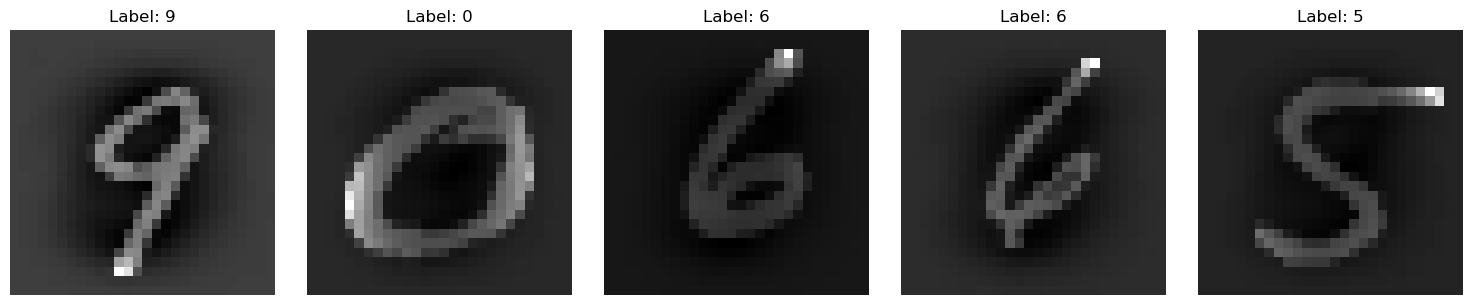

Labels: [9 0 6 6 5]


In [146]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    X_i = X_train[i].reshape((28, 28))
    axes[i].imshow(X_i, cmap=plt.cm.gray)
    axes[i].set_title(f'Label: {int(Y_train[i])}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("Labels:", Y_train[:5].astype(int))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Now, do logistic regression in the following way:

1. Scale data to have zero mean and unit variance (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) <br>
  `scaler = StandardScaler()` <br>
  `X_train = scaler.fit_transform(X_train)` <br>
  `X_test = scaler.transform(X_test)` <br>
2. Make an instance of the model using LogisticRegression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Try "liblinear" and "sag" optimization algorithms.<br>
  $\textbf{liblinear}$: Use solver='liblinear' and use L1 norm in the penalization (penalty='l1'). Also set C=1e5 and tol=.3<br>
  $\textbf{sag}$: Use solver='sag' and use L2 norm in the penalization (penalty='l2'). Also set C=1e5 and tol=.1<br>
  e.g. `model = LogisticRegression(...)` <br>
3. Train the model on the data <br>
  e.g. `model.fit(training X sample, training Y samples)` <br>
4. Predict the labels of test data.<br>
  e.g. `digit_predict = model.predict(test X samples)` <br>
5. Compute the accuracy<br>
  e.g. `model.score(test X samples, test Y samples)` <br>
  
<span style="color:blue"> <i> 3. Using both liblinear and sag solvers, compute the accuracy of the test samples. Also, measure the training time (how long it takes to train the model on the data) using time.time().  </i></span> <br>


In [147]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import time

t0 = time.time()
liblinear = LogisticRegression(solver='liblinear', penalty='l1', C=1e5, tol=0.3, random_state=rng_seed, max_iter=1000)
liblinear.fit(X_train_scaled, Y_train)
run_time_liblinear = time.time() - t0
score_liblinear = liblinear.score(X_test_scaled, Y_test)
print('liblinear:')
print('Run time: %.3f s' % run_time_liblinear)
print('accuracy: %.3f' % score_liblinear)

t0 = time.time()
sag = LogisticRegression(solver='sag', penalty='l2', C=1e5, tol=0.1, random_state=rng_seed, max_iter=1000)
sag.fit(X_train_scaled, Y_train)
run_time_SGD = time.time() - t0
score_SGD = sag.score(X_test_scaled, Y_test)
print('sag:')
print('Run time: %.3f s' % run_time_SGD)
print('accuracy: %.3f' % score_SGD)

liblinear:
Run time: 0.340 s
accuracy: 0.861
sag:
Run time: 0.185 s
accuracy: 0.875


In [148]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<span style="color:blue"> <i> 4. Choose any 15 images and show what the images look like. What are the predicted labels corresponding to them? Take a look at the misclassified samples. Use the sag solver. </i></span> <br>


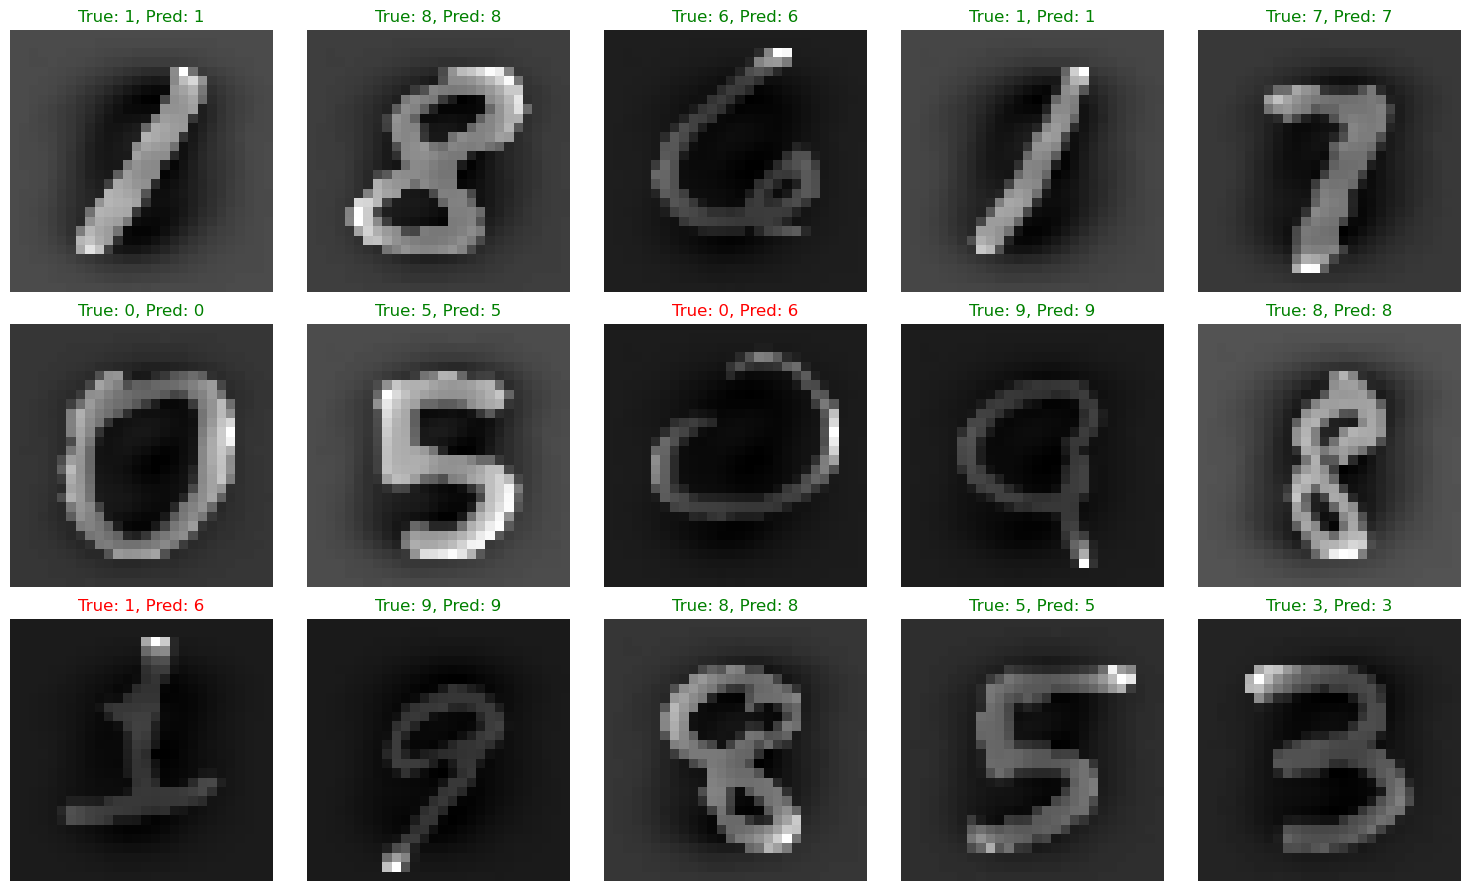

Number of misclassified samples: 95
First few misclassified indices: [  7  10  20  45  63  71  73  93  97 100]


In [149]:
# Get predictions for test set
Y_pred = sag.predict(X_test_scaled)

# Display 15 images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    X_i = X_test[i].reshape((28, 28))
    axes[i].imshow(X_i, cmap=plt.cm.gray)
    axes[i].set_title(f'True: {int(Y_test[i])}, Pred: {int(Y_pred[i])}', 
                     color='green' if Y_test[i] == Y_pred[i] else 'red')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Show misclassified samples
misclassified = np.where(Y_test != Y_pred)[0]
print(f"Number of misclassified samples: {len(misclassified)}")
if len(misclassified) > 0:
    print(f"First few misclassified indices: {misclassified[:10]}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Here, we have 10 classes and 784 features. Using "coef_", we can get the coefficient of the features in the decision function. These are basically classication "weights."

<span style="color:blue"> <i> 5. Obtain the coefficient of the features for the model using the sag solver. (`coef = sag.coef_`) This is a 10x784 matrix. (number of classes x number of features) Reshape it into 28x28 and make a plot for each class. How do they look? Can you recognize the digits? </i></span> <br>


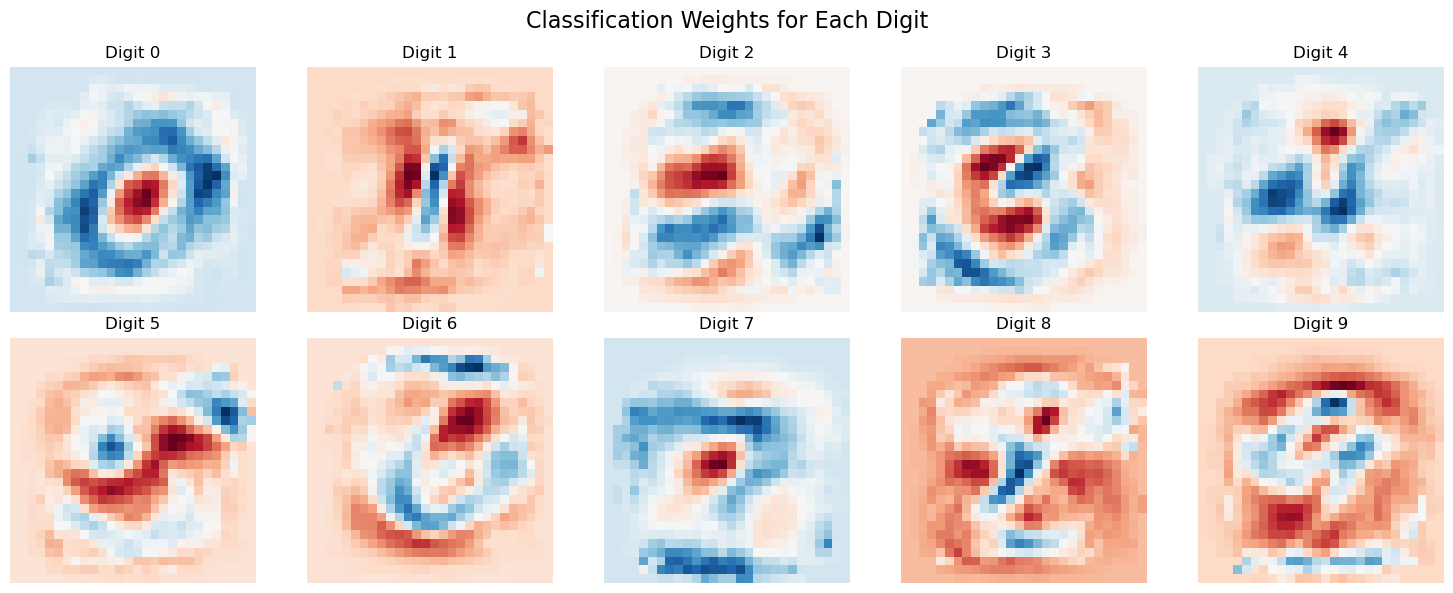

In [150]:
# Get coefficients from sag model
coef = sag.coef_

# Plot coefficients for each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    coef_image = coef[i].reshape((28, 28))
    axes[i].imshow(coef_image, cmap=plt.cm.RdBu, interpolation='nearest')
    axes[i].set_title(f'Digit {i}')
    axes[i].axis('off')

plt.suptitle('Classification Weights for Each Digit', fontsize=16)
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

***

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit the notebook (not the zip) to Gradescope! For the PDF submission, use Cmd + P to get the notebook!

In [152]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)